<a href="https://colab.research.google.com/github/sbg0700/Larvathon1st/blob/main/Larvathon_PRJ_codebase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ï†úÍ±∞Îêú(ÎàÑÏàò Í∞ÄÎä•) Î≥ÄÏàò: ['HbA1c_any']
SMOTE Ï†ÅÏö© ÌõÑ Îç∞Ïù¥ÌÑ∞ Î∂ÑÌè¨: [8276 8276]
‚úÖ Logit ROC-AUC: 0.704 | AP(PR-AUC): 0.208
‚úÖ RF    ROC-AUC: 0.763 | AP(PR-AUC): 0.219

ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í(Logit): 0.183, F1=0.291
ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í(RF): 0.331, F1=0.317

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.94      0.71      0.81      2069
           1       0.19      0.62      0.29       230

    accuracy                           0.70      2299
   macro avg       0.57      0.66      0.55      2299
weighted avg       0.87      0.70      0.76      2299

RandomForest Report:
               precision    recall  f1-score   support

           0       0.94      0.78      0.85      2069
           1       0.22      0.57      0.32       230

    accuracy                           0.75      2299
   macro avg       0.58      0.67      0.58      2299
weighted avg       0.87      0.75      0.80      2299



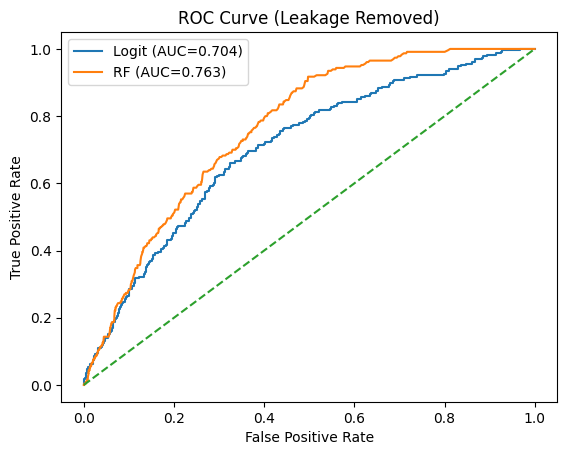

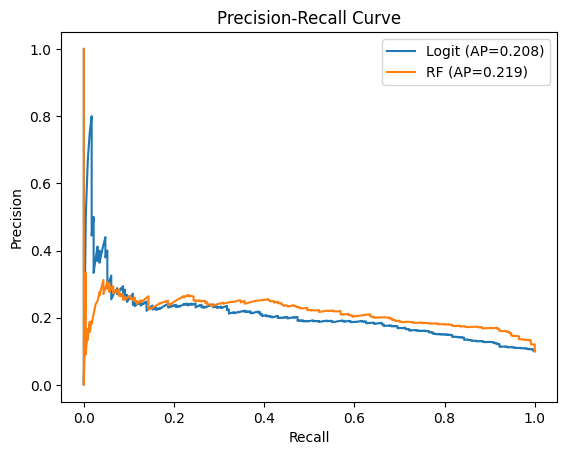

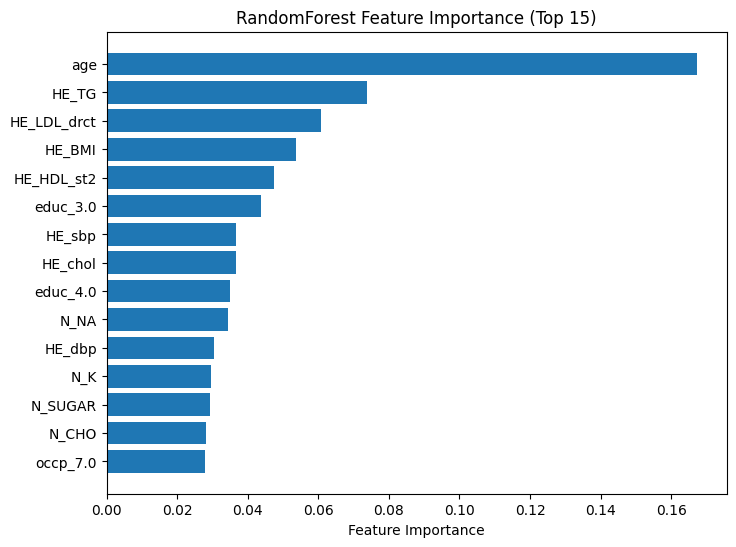

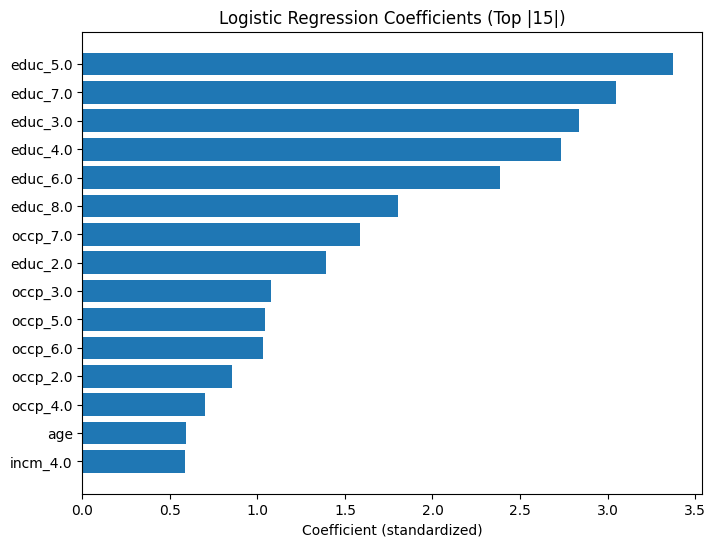

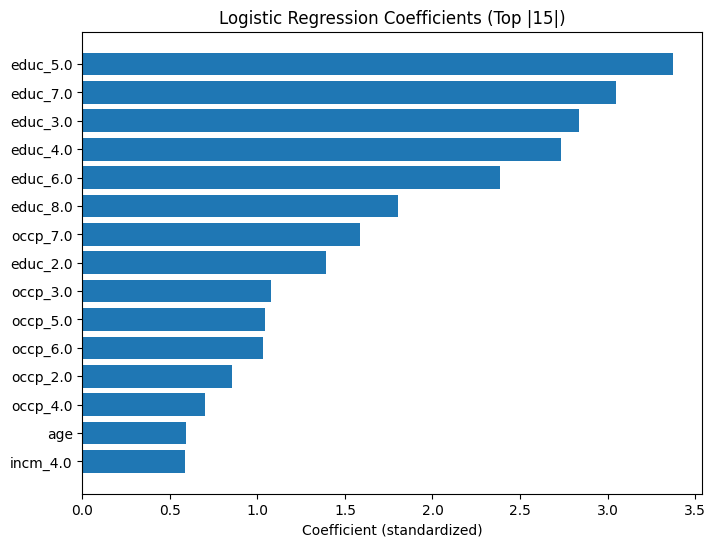

In [1]:
# -*- coding: utf-8 -*-
"""
Ï£ºÏ†ú: Í±¥Í∞ïÍ≤ÄÏßÑ¬∑ÏòÅÏñëÏÑ≠Ï∑® Îç∞Ïù¥ÌÑ∞Î°ú 'ÎãπÎá® ÏúÑÌóò(0/1)' ÏòàÏ∏° (Ïù¥ÏßÑ Î∂ÑÎ•ò)
Îç∞Ïù¥ÌÑ∞: modeling_dataset_hba1c_Excel.csv (EUC-KR/CP949 Ïù∏ÏΩîÎî©)
ÌÉÄÍπÉ(y): 'ÎãπÎá®_ÏúÑÌóò' = 1 if HbA1c >= 6.5 else 0  (Ïù¥ÎØ∏ CSVÏóê Ìè¨Ìï®ÎêòÏñ¥ ÏûàÏùå)
Ï§ëÏöî: ÏûÖÎ†• ÌîºÏ≤ò(X)ÏóêÏÑúÎäî HbA1c Í¥ÄÎ†® Î≥ÄÏàò(HbA1c_any, HE_HbA1c Îì±)Î•º Ï†úÍ±∞Ìï¥ 'Îç∞Ïù¥ÌÑ∞ ÎàÑÏàò(Leakage)'Î•º Î∞©ÏßÄ

Î™®Îç∏:
 - Logistic Regression (Ìï¥ÏÑù Ïö©Ïù¥, ÏÑ†Ìòï)
 - Random Forest (ÎπÑÏÑ†Ìòï ÏÉÅÌò∏ÏûëÏö©, Ï§ëÏöîÎèÑ Ìï¥ÏÑù)

ÌèâÍ∞Ä/ÏãúÍ∞ÅÌôî:
 - ROC-AUC, PR-AUC, Î∂ÑÎ•òÎ¶¨Ìè¨Ìä∏(precision/recall/f1)
 - ROC Í≥°ÏÑ†(Îëê Î™®Îç∏), PR Í≥°ÏÑ†(Îëê Î™®Îç∏)
 - RF Feature Importance Top 15
 - Logit Í≥ÑÏàò(ÌëúÏ§ÄÌôî ÌõÑ Ï†àÎåìÍ∞í Top 15, Î∞©Ìñ•ÏÑ± Ìè¨Ìï®)

ÏÇ¨Ïö© Î∞©Î≤ï:
 1) ÏΩîÎû©Ïóê Ïù¥ ÏÖÄÏùÑ Í∑∏ÎåÄÎ°ú Ïã§Ìñâ
 2) '/content' Í≤ΩÎ°úÏóê CSV ÏóÖÎ°úÎìú ÌõÑ Í≤ΩÎ°ú ÌôïÏù∏
 3) Í≤∞Í≥º ÏàòÏπòÏôÄ Í∑∏ÎûòÌîÑÎ•º Ìï¥ÏÑù
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV  # Ï∂îÍ∞ÄÎêú ÏΩîÎî©
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# üö® Î∂àÍ∑†Ìòï Îç∞Ïù¥ÌÑ∞ Î≥¥Ï†ïÏö© (SMOTE) Ï∂îÍ∞ÄÎêú ÏΩîÎî©
from imblearn.over_sampling import SMOTE
# -------------------------------------------------------------
# 1) Îç∞Ïù¥ÌÑ∞ Î°úÎìú
#   - ÏóëÏÖÄ Ìò∏Ìôò Ï†ÄÏû•(CP949/EUC-KR) ÌååÏùº Í∞ÄÏ†ï
#   - Ïù∏ÏΩîÎî© Ïù¥ÏäàÍ∞Ä ÏûàÏúºÎ©¥ encoding='cp949' ÎòêÎäî 'euc-kr'Î°ú ÏãúÎèÑ
# -------------------------------------------------------------
DATA_PATH = '/content/modeling_dataset_hba1c_Excel.csv'
assert os.path.exists(DATA_PATH), f"CSVÍ∞Ä Î≥¥Ïù¥ÏßÄ ÏïäÏäµÎãàÎã§: {DATA_PATH} Ïóê ÏóÖÎ°úÎìúÌïòÏÑ∏Ïöî."

df = pd.read_csv(DATA_PATH, encoding='cp949')  # 'euc-kr'ÎèÑ ÎèôÏùº

# -------------------------------------------------------------
# 2) Îç∞Ïù¥ÌÑ∞ ÎàÑÏàò Î∞©ÏßÄ: HbA1c Í¥ÄÎ†® Ïó¥ Ï†úÍ±∞
#   - ÌÉÄÍπÉ ÏÉùÏÑ±Ïóê ÏßÅÏ†ë Ïì∞Ïù∏ ÏßÄÌëúÎäî ÏûÖÎ†• ÌîºÏ≤òÏóêÏÑú Ï†úÍ±∞Ìï¥Ïïº Ìï®
#   - Ïòà: 'HbA1c_any', 'HE_HbA1c', 'HE_DM_HbA1c' Îì±
# -------------------------------------------------------------
drop_cols = [c for c in df.columns if ('hba1c' in c.lower()) or ('_dm_' in c.lower())]
print("Ï†úÍ±∞Îêú(ÎàÑÏàò Í∞ÄÎä•) Î≥ÄÏàò:", drop_cols)
df = df.drop(columns=drop_cols, errors='ignore')

# -------------------------------------------------------------
# 3) ÏûÖÎ†•(X)/ÌÉÄÍπÉ(y) Î∂ÑÎ¶¨ ->  3) ÏûÖÎ†•(X)/ÌÉÄÍπÉ(y)
#   - y: 'ÎãπÎá®_ÏúÑÌóò' (0/1)
#   - X: ÎÇòÎ®∏ÏßÄ ÌîºÏ≤ò
# -------------------------------------------------------------
assert 'ÎãπÎá®_ÏúÑÌóò' in df.columns, "'ÎãπÎá®_ÏúÑÌóò' Ïª¨ÎüºÏù¥ ÏóÜÏäµÎãàÎã§."
y = df['ÎãπÎá®_ÏúÑÌóò'].astype(int)
X = df.drop(columns=['ÎãπÎá®_ÏúÑÌóò'])

# -------------------------------------------------------------
# 4) ÏΩîÎìúÌòï(Î≤îÏ£ºÌòï)Ï≤òÎüº Î≥¥Ïù¥Îäî Ïà´ÏûêÏó¥ÏùÑ ÎçîÎØ∏Ìôî(ÏÑ†ÌÉù) ->
# 4) ÏΩîÎìúÌòï Î≥ÄÏàò ÎçîÎØ∏Ìôî
#   - Ìä∏Î¶¨ Î™®Îç∏ÏùÄ ÎçîÎØ∏ÌôîÍ∞Ä ÌïÑÏàòÎäî ÏïÑÎãàÏßÄÎßå
#   - Î°úÏßÄÏä§Ìã± ÌöåÍ∑Ä Í≥ÑÏàò Ìï¥ÏÑùÎ†• Ìñ•ÏÉÅÏùÑ ÏúÑÌï¥ Í∂åÏû•
# -------------------------------------------------------------
code_like = [c for c in ['sex', 'educ', 'incm', 'occp'] if c in X.columns]
X = pd.get_dummies(X, columns=code_like, drop_first=True)

feature_names = X.columns.tolist()

# -------------------------------------------------------------
# 5) Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† (Ï∏µÌôî: ÏñëÏÑ±/ÏùåÏÑ± ÎπÑÏú® Ïú†ÏßÄ) ->
# 5) Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† (Ï∏µÌôî Ïú†ÏßÄ)
#   - Ïû¨ÌòÑ Í∞ÄÎä•ÏÑ± ÌôïÎ≥¥Î•º ÏúÑÌï¥ random_state Í≥†Ï†ï
# -------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#-------------------------------------------------------------
# ‚ùó ÏàòÏ†ï Ï†Ñ: Î∂àÍ∑†Ìòï Í∑∏ÎåÄÎ°ú ÌïôÏäµ
# logit.fit(X_train, y_train)
# rf.fit(X_train, y_train)
# -------------------------------------------------------------
# ‚úÖ ÏàòÏ†ï ÌõÑ: Î∂àÍ∑†Ìòï Î≥¥Ï†ï (SMOTE Ï†ÅÏö©)
# Ïù¥Ïú†: 'ÎãπÎá®_ÏúÑÌóò=1'Ïù¥ ÎÑàÎ¨¥ Ï†ÅÏúºÎ©¥ Î™®Îç∏Ïù¥ 0Îßå ÏòàÏ∏°ÌïòÎäî Í≤ΩÌñ•.
# SMOTEÎäî 1(ÏñëÏÑ±) Îç∞Ïù¥ÌÑ∞Î•º Î≥µÏ†úÌï¥ÏÑú ÌïôÏäµ Í∑†ÌòïÏùÑ ÎßûÏ∂∞Ï§å.
# -------------------------------------------------------------
sm = SMOTE(random_state=42)  # Ï∂îÍ∞ÄÎêú ÏΩîÎî©
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)  # Ï∂îÍ∞ÄÎêú ÏΩîÎî©
print(f"SMOTE Ï†ÅÏö© ÌõÑ Îç∞Ïù¥ÌÑ∞ Î∂ÑÌè¨: {np.bincount(y_train_res)}")  # Ï∂îÍ∞ÄÎêú ÏΩîÎî©


# -------------------------------------------------------------
# 6) Î™®Îç∏ Íµ¨ÏÑ±
#   - LogisticRegression: ÌëúÏ§ÄÌôî + class_weight='balanced' (Î∂àÍ∑†Ìòï Î≥¥Ï†ï)
#   - RandomForest: class_weight='balanced_subsample'
# -------------------------------------------------------------
logit = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced'))
])

# -------------------------------------------------------------
# ‚ùó ÏàòÏ†ï Ï†Ñ:
# rf = RandomForestClassifier(
#     n_estimators=500, random_state=42, n_jobs=-1, class_weight='balanced_subsample'
# )
# -------------------------------------------------------------
# ‚úÖ ÏàòÏ†ï ÌõÑ (ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù Ï∂îÍ∞Ä)
# Ïù¥Ïú†: Îã®Ïàú Í∏∞Î≥∏Í∞íÎ≥¥Îã§ ÍµêÏ∞®Í≤ÄÏ¶ùÏùÑ ÌÜµÌï¥ ÏÑ±Îä• Ï¢ãÏùÄ Ï°∞Ìï©ÏùÑ Ï∞æÍ∏∞ ÏúÑÌï®
rf_base = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')

param = {  # Ï∂îÍ∞ÄÎêú ÏΩîÎî©
    'n_estimators': [300, 500, 700],
    'max_depth': [None, 8, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 0.5]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Ï∂îÍ∞ÄÎêú ÏΩîÎî©
rf_search = RandomizedSearchCV(rf_base, param, n_iter=10, scoring='average_precision',
                               cv=cv, n_jobs=-1, random_state=42)  # Ï∂îÍ∞ÄÎêú ÏΩîÎî©

# -------------------------------------------------------------
# 7) ÌïôÏäµ
# -------------------------------------------------------------
# ‚ùó ÏàòÏ†ï Ï†Ñ:
# -------------------------------------------------------------
# logit.fit(X_train, y_train)
# rf.fit(X_train, y_train)
# -------------------------------------------------------------
# ‚úÖ ÏàòÏ†ï ÌõÑ
# -------------------------------------------------------------
logit.fit(X_train_res, y_train_res)  # SMOTE Îç∞Ïù¥ÌÑ∞Î°ú ÌïôÏäµ
rf_search.fit(X_train_res, y_train_res)  # Ï∂îÍ∞ÄÎêú ÏΩîÎî©
rf = rf_search.best_estimator_  # ÏµúÏ†Å Î™®Îç∏Î°ú ÍµêÏ≤¥ (Ï∂îÍ∞ÄÎêú ÏΩîÎî©)

# -------------------------------------------------------------
# # 8) ÏòàÏ∏° Ï†êÏàò(ÌôïÎ•†) Î∞è ÌèâÍ∞ÄÏßÄÌëú -> 8) ÏòàÏ∏° Î∞è ÌèâÍ∞ÄÏßÄÌëú
#   - ROC-AUC: ÏûÑÍ≥ÑÍ∞í Ï†ÑÎ∞òÏùò Íµ¨Î∂ÑÎ†•
#   - PR-AUC(AP): ÏñëÏÑ± ÎπÑÏú®Ïù¥ ÎÇÆÏùÑ Îïå Îçî ÏßÅÍ¥ÄÏ†Å
#   - classification_report: precision/recall/f1
# -------------------------------------------------------------
proba_logit = logit.predict_proba(X_test)[:, 1]
proba_rf    = rf.predict_proba(X_test)[:, 1]

roc_auc_logit = roc_auc_score(y_test, proba_logit)
roc_auc_rf    = roc_auc_score(y_test, proba_rf)

prec_l, rec_l, thr_l = precision_recall_curve(y_test, proba_logit)
prec_r, rec_r, thr_r = precision_recall_curve(y_test, proba_rf)
ap_l = average_precision_score(y_test, proba_logit)
ap_r = average_precision_score(y_test, proba_rf)

print(f"‚úÖ Logit ROC-AUC: {roc_auc_logit:.3f} | AP(PR-AUC): {ap_l:.3f}")
print(f"‚úÖ RF    ROC-AUC: {roc_auc_rf:.3f} | AP(PR-AUC): {ap_r:.3f}\n")
# -------------------------------------------------------------
# ‚ùó ÏàòÏ†ï Ï†Ñ: ÏûÑÍ≥ÑÍ∞í Í≥†Ï†ï(0.5) ÏòàÏ∏°
# print("Logistic Regression Report:\n", classification_report(y_test, logit.predict(X_test)))
# print("RandomForest Report:\n", classification_report(y_test, rf.predict(X_test)))
# print(classification_report(y_test, logit.predict(X_test)))
# -------------------------------------------------------------
# ‚úÖ ÏàòÏ†ï ÌõÑ: F1 Ï†êÏàòÍ∞Ä Í∞ÄÏû• ÎÜíÏùÄ ÏûÑÍ≥ÑÍ∞í ÏûêÎèô ÏÑ†ÌÉù
# Ïù¥Ïú†: ÏùòÎ£åÏóêÏÑúÎäî "Ï†ïÎ∞ÄÎèÑÏôÄ Ïû¨ÌòÑÏú®Ïùò Í∑†Ìòï"Ïù¥ Îçî Ï§ëÏöîÌï®.
# -------------------------------------------------------------
def best_threshold(y_true, proba):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1s = 2 * (prec * rec) / (prec + rec + 1e-6)
    idx = np.argmax(f1s)
    return thr[idx], f1s[idx]

thr_logit, best_f1_logit = best_threshold(y_test, proba_logit)
thr_rf, best_f1_rf = best_threshold(y_test, proba_rf)

print(f"ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í(Logit): {thr_logit:.3f}, F1={best_f1_logit:.3f}")
print(f"ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í(RF): {thr_rf:.3f}, F1={best_f1_rf:.3f}\n")

y_pred_logit = (proba_logit >= thr_logit).astype(int)
y_pred_rf = (proba_rf >= thr_rf).astype(int)

print("Logistic Regression Report:\n", classification_report(y_test, y_pred_logit))
print("RandomForest Report:\n", classification_report(y_test, y_pred_rf))

# -------------------------------------------------------------
# 9) ROC Í≥°ÏÑ† (Îëê Î™®Îç∏ Ìïú ÌîåÎ°Ø) -> 9) ROC Í≥°ÏÑ†
#   - x: FPR(ÏúÑÏñëÏÑ±Î•†), y: TPR(Ïû¨ÌòÑÏú®)
#   - ÎåÄÍ∞ÅÏÑ†: ÎûúÎç§ Ï∂îÏ†ï Í∏∞Ï§ÄÏÑ†
# -------------------------------------------------------------
fpr_l, tpr_l, _ = roc_curve(y_test, proba_logit)
fpr_r, tpr_r, _ = roc_curve(y_test, proba_rf)

plt.figure()
plt.plot(fpr_l, tpr_l, label=f'Logit (AUC={roc_auc_logit:.3f})')
plt.plot(fpr_r, tpr_r, label=f'RF (AUC={roc_auc_rf:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Leakage Removed)')
plt.legend()
plt.show()

# -------------------------------------------------------------
# 10) Precision-Recall Í≥°ÏÑ†
#   - ÏñëÏÑ± ÎìúÎ¨∏ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Î™®Îç∏ ÎπÑÍµêÏãú Ïú†Ïö©
# -------------------------------------------------------------
plt.figure()
plt.plot(rec_l, prec_l, label=f'Logit (AP={ap_l:.3f})')
plt.plot(rec_r, prec_r, label=f'RF (AP={ap_r:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# -------------------------------------------------------------
# 11) RandomForest Feature Importance (Top 15)
#   - Ìä∏Î¶¨ Î∂ÑÌï†ÏóêÏÑúÏùò ÌèâÍ∑† Í∏∞Ïó¨ÎèÑ(ÏÉÅÎåÄÏßÄÌëú)
# -------------------------------------------------------------
importances = rf.feature_importances_
idx = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(8, 6))
plt.barh(range(len(idx)), importances[idx][::-1])
plt.yticks(range(len(idx)), [feature_names[i] for i in idx][::-1])
plt.xlabel('Feature Importance')
plt.title('RandomForest Feature Importance (Top 15)')
plt.show()

# -------------------------------------------------------------
# 12) Logistic Regression Í≥ÑÏàò (Top |15|)
#   - ÌëúÏ§ÄÌôîÎêú Í≥ÑÏàò ‚Üí Ïñë(+)Ïù¥Î©¥ ÏúÑÌóò ‚Üë, Ïùå(-)Ïù¥Î©¥ ÏúÑÌóò ‚Üì Î∞©Ìñ•ÏÑ±
# -------------------------------------------------------------
coefs = logit.named_steps['clf'].coef_[0]
coef_idx = np.argsort(np.abs(coefs))[::-1][:15]

plt.figure(figsize=(8, 6))
plt.barh(range(len(coef_idx)), coefs[coef_idx][::-1])
plt.yticks(range(len(coef_idx)), [feature_names[i] for i in coef_idx][::-1])
plt.xlabel('Coefficient (standardized)')
plt.title('Logistic Regression Coefficients (Top |15|)')
plt.show()

# -------------------------------------------------------------
# ‚ùó ÏàòÏ†ï Ï†Ñ: 13) Í∞ÑÎã® Í∞ÄÏù¥ÎìúÎùºÏù∏ (Ï∂úÎ†•Ïö©)
#print("\n[Ìï¥ÏÑù Í∞ÄÏù¥Îìú]")
# print("- ROC-AUC 0.75~0.85: ÏùòÎ£å ÏòàÏ∏°ÏóêÏÑú ÌòÑÏã§Ï†ÅÏù∏ Î≤îÏúÑ")
# print("- PR-AUC(AP)Îäî ÏñëÏÑ± Ï†ÅÏùÄ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Îçî informative")
# print("- RF Ï§ëÏöîÎèÑ: 'ÎÇòÏù¥, BMI, TG, LDL, SBP, SUGAR' Îì±Ïù¥ ÏÉÅÏúÑ ‚Üí ÏûÑÏÉÅÏ†Å ÌÉÄÎãπÏÑ± Ï†êÍ≤Ä")
# print("- Logit Í≥ÑÏàò Î∂ÄÌò∏: +Î©¥ ÏúÑÌóò‚Üë, -Î©¥ ÏúÑÌóò‚Üì (ÌëúÏ§ÄÌôî Í∏∞Ï§Ä; Ïä§ÏºÄÏùº ÏòÅÌñ• Ï†úÍ±∞)")
# print("- Ïö¥ÏòÅ Î™©Ï†ÅÏóê ÎßûÍ≤å ÏûÑÍ≥ÑÍ∞í Ï°∞Ï†ï(0.5‚Üí0.4/0.6)ÏúºÎ°ú Ï†ïÎ∞ÄÎèÑ/Ïû¨ÌòÑÏú® Ìä∏Î†àÏù¥ÎìúÏò§ÌîÑ Ï°∞Ï†à")
#-------------------------------------------------------------
# ‚úÖ ÏàòÏ†ï ÌõÑ: 12) Logistic Regression Í≥ÑÏàò (Top |15|)
coefs = logit.named_steps['clf'].coef_[0]
coef_idx = np.argsort(np.abs(coefs))[::-1][:15]
plt.figure(figsize=(8, 6))
plt.barh(range(len(coef_idx)), coefs[coef_idx][::-1])
plt.yticks(range(len(coef_idx)), [feature_names[i] for i in coef_idx][::-1])
plt.xlabel('Coefficient (standardized)')
plt.title('Logistic Regression Coefficients (Top |15|)')
plt.show()
